In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata

%matplotlib inline

In [30]:
# Returns a 0/1 mask of where the domino likely is in the image
# Note: this (intentionally) only works on the curated tile dataset!!!!!!!
def threshold(img_bw):
    # Because I took the photos in a regular way,
    # segmenting out the relevant pixels is pretty straight forward
    # There are four primary boundaries on these photos
    # 1) the white paper, which has a high intensity
    # 2) the shadow the rectangle is casting, which has a high intensity but lower than paper
    # 3) the edge of the rectangle, usually only visilbe in the font as a thick black line
    # 4) the rectangle itself.
    upper_threshold = np.mean(img_bw)  # eliminate paper
    lower_threshold = np.mean(img_bw) - 4*np.std(img_bw) # eliminate shadow
    mask = np.logical_and(img_bw < upper_threshold, img_bw > lower_threshold)
    
    result = img_bw.copy()
    result[mask] = 1
    result[~mask] = 0
    return result

# Helper function to apply a mask to 3 channels
def maskIm(mask, image):
    result = np.zeros(image.shape).astype(image.dtype)
    for c in range(3):
        result[:,:,c] = (mask > 0) * image[:, :, c]
    return result

# Finds the corners of the quad formed by threshold
# Returns (xs, ys) where xs is a list of 4 x-points, and similar for ys
#  If the top-left of the image is (0,0), then the extent index i is...
# i = 0   Bottom-Left
# i = 1   Top-left
# i = 2   Bottom-Right
# i = 3   Top-Right
def findExtents(img_mask):
    H, W = img_mask.shape
    test = np.nonzero(img_mask)
    extent_x = [ W, W, 0, 0 ]
    extent_y = [ 0, H, 0, H ]
    midx = W // 2
    midy = H // 2
    for (y, x) in zip(test[0], test[1]):
        if (x < midx):
            if (y < midy):
                if (x < extent_x[1]): extent_x[1] = x
                if (y < extent_y[1]): extent_y[1] = y
            else:
                if (x < extent_x[0]): extent_x[0] = x
                if (y > extent_y[0]): extent_y[0] = y
        else:
            if (y < midy):
                if (x > extent_x[3]): extent_x[3] = x
                if (y < extent_y[3]): extent_y[3] = y
            else:
                if (x > extent_x[2]): extent_x[2] = x
                if (y > extent_y[2]): extent_y[2] = y

    # Hack to fix pencil mark at point 0, and shadow visible along bottom
    extent_x[0] += 11
    extent_y[0] -= 30
    extent_y[2] -= 30
                    
    return (extent_x, extent_y)

# Given extents, find the affine matrices that translate the two triangles formed by them
#  to two right trangles spanning a known rectangle of width=2*res and height=res
# Returns a dictionary
#  {
#      "P":    3x3 affine matrix mapping pixel to standard rect, upper half-rectangle T1 (extent 1-0-3)
#      "Pinv": 3x3 affine matrix mapping standard rect to pixel, lower half-rectangle T1
#      "Q":    3x3 affine matrix mapping pixel to standard rect, upper half-rectangle T2 (extent 2-0-3)
#      "Qinv": 3x3 affine matrix mapping standard rect to pixel, lower half-rectangle T2
# }
def findLinearMap(extents, res = 128):
    # the following setups mapping of rhombus identified above to a rectangle with corners (0,0) and (2,1)
    T1 = np.zeros((6,6)) 
    T2 = np.zeros((6,6))
    c1 = np.zeros(6)
    c2 = np.zeros(6)
    
    extent_x, extent_y = extents

    T1 = np.array([
        [extent_x[1], extent_y[1], 1,           0, 0, 0],
        [extent_x[0], extent_y[0], 1,           0, 0, 0],
        [extent_x[3], extent_y[3], 1,           0, 0, 0],
        [          0,           0, 0, extent_x[1], extent_y[1], 1],
        [          0,           0, 0, extent_x[0], extent_y[0], 1],
        [          0,           0, 0, extent_x[3], extent_y[3], 1]
    ])
    c1 = [ 0, 0, 256, 0, 128, 0 ]

    T2 = np.array([
        [extent_x[2], extent_y[2], 1,           0, 0, 0],
        [extent_x[0], extent_y[0], 1,           0, 0, 0],
        [extent_x[3], extent_y[3], 1,           0, 0, 0],
        [          0,           0, 0, extent_x[2], extent_y[2], 1],
        [          0,           0, 0, extent_x[0], extent_y[0], 1],
        [          0,           0, 0, extent_x[3], extent_y[3], 1]
    ])
    c2 = [ 256, 0, 256, 128, 128, 0 ]

    t1_est = np.linalg.solve(T1, c1)
    t2_est = np.linalg.solve(T2, c2)

    P = np.array([
        [t1_est[0], t1_est[1], t1_est[2]],
        [t1_est[3], t1_est[4], t1_est[5]],
        [        0,         0,         1]])

    Pinv = np.linalg.inv(P)

    Q = np.array([
        [t2_est[0], t2_est[1], t2_est[2]],
        [t2_est[3], t2_est[4], t2_est[5]],
        [        0,         0,         1]])
    Qinv = np.linalg.inv(Q)
    return {
        "P": P, "Pinv": Pinv, "Q": Q, "Qinv": Qinv
    }

# Utility to try to detect the rectangle/rhombus
# in the image and map onto a standard rectangle.
def cropTile(img, res = 128, debug = True):
    
    start = time.time()
    print("Crop Tile beginning with image of shape {0} targetting res {1}".format(img.shape, (res,2*res)))
    
    # Do the edge detection on the intensity
    tick = time.time()
    mask = threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    tock = time.time()
    print("Threshold took {0} seconds.  {1} seconds elapsed total". format(tock - tick, tock - start))
          
    tick = time.time()
    extents = findExtents(mask)    
    tock = time.time()
    print("Find Extents took {0} seconds.  {1} seconds elapsed total". format(tock - tick, tock - start))

    tick = time.time()
    linearMap = findLinearMap(extents)
    tock = time.time()
    print("Find Linear Map took {0} seconds.  {1} seconds elapsed total". format(tock - tick, tock - start))

    tick = time.time()
    Pinv = linearMap["Pinv"]
    Qinv = linearMap["Qinv"]

          
    # Short hand functions to apply the linear map
    def t1IMap(xs, ys):
        rx = Pinv[0, 0] * xs + Pinv[0, 1] * ys + Pinv[0, 2]
        ry = Pinv[1, 0] * xs + Pinv[1, 1] * ys + Pinv[1, 2]
        return rx, ry
    
    def t2IMap(xs, ys):
        rx = Qinv[0, 0] * xs + Qinv[0, 1] * ys + Qinv[0, 2]
        ry = Qinv[1, 0] * xs + Qinv[1, 1] * ys + Qinv[1, 2]
        return rx, ry

    # Evaluate the map on a grid across the standard rectangle
    ys, xs= np.mgrid[0:res, 0:(2*res)]
    t1_oxs, t1_oys = t1IMap(xs, ys)
    t2_oxs, t2_oys = t2IMap(xs, ys)
    
    # Get a mask to pick which map we should use for each pixel, T1 or T2
    slope = 0.5
    triangle_mask = (res - ys) > slope*xs
    
    # Stating pixel locations as entries in a new dataset
    old_grid_y, old_grid_x = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    croppedResult = np.zeros((res, 2*res, 3))
    tock = time.time()
    print("Data Prep for Griddaata took {0} seconds.  {1} seconds elapsed total". format(tock - tick, tock - start))
          
    for c in range(3):
        tick = time.time()
        t1_interp = griddata(np.stack((old_grid_x, old_grid_y)).transpose().reshape(-1, 2),
                             img[:,:,c].T.flatten(),
                             (t1_oxs, t1_oys))
        t2_interp = griddata(np.stack((old_grid_x, old_grid_y)).transpose().reshape(-1, 2),
                             img[:,:,c].T.flatten(),
                             (t2_oxs, t2_oys))
        croppedResult[triangle_mask,c] = t1_interp[triangle_mask]
        croppedResult[~triangle_mask,c] = t2_interp[~triangle_mask]
        tock = time.time()
        print("Interpolation on Channel {2} took {0} seconds.  {1} seconds elapsed total". format(tock - tick, tock - start, c))
  
    return croppedResult.astype('uint8')

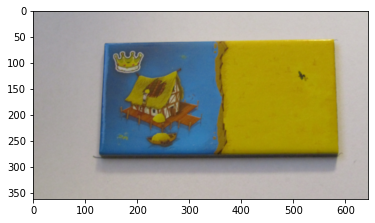

Crop Tile beginning with image of shape (362, 644, 3) targetting res (128, 256)
Threshold took 0.0015552043914794922 seconds.  0.001611471176147461 seconds elapsed total
Find Extents took 0.05514097213745117 seconds.  0.056803226470947266 seconds elapsed total
Find Linear Map took 0.0002608299255371094 seconds.  0.0571746826171875 seconds elapsed total
Data Prep for Griddaata took 0.0016946792602539062 seconds.  0.05890846252441406 seconds elapsed total
Interpolation on Channel 0 took 7.64447021484375 seconds.  7.703433036804199 seconds elapsed total
Interpolation on Channel 1 took 7.660533428192139 seconds.  15.36440658569336 seconds elapsed total
Interpolation on Channel 2 took 7.618961572647095 seconds.  22.983845949172974 seconds elapsed total


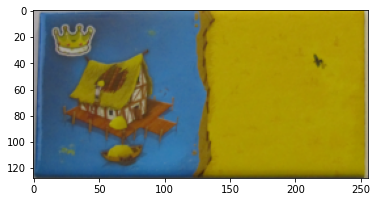

In [31]:
files = [ "IMG_0" + str(i) + ".JPG" for i in range(623, 669) ]
prefix = "raw_tiles/"
outfix = "processed_tiles/"

# These are the backsides of the tiles.  I don't think they will be important
#  for the project, but they may come in handy later.
tiles = [ 30, 34, 17, 33, 45, 43, 16, 46, 9, 10, 8, 24, 21, 25, 31,
           36, 6, 15, 41, 42, 37, 7, 47, 48, 39, 40, 27, 29, 35, 3,
         26, 23, 20, 1, 22, 38, 19, 14, 13, 32, 12, 44, 5, 4, 18, 28, 2, 11 ]

for i, file in enumerate(files):
    tmp = cv2.imread(prefix + file)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    tmp = cv2.pyrDown(cv2.pyrDown(cv2.pyrDown(tmp)))
    
    plt.figure()
    plt.imshow(tmp)
    plt.show()
    
    cropped_tile = cropTile(tmp)
    
    plt.figure()
    plt.imshow(cropped_tile)
    plt.show()
    
    out = outfix + "cropped_tile_"
    if (tiles[i] < 10): out += "0" 
    out += str(tiles[i]) + ".png"
    cropped_tile = cv2.cvtColor(cropped_tile, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out, cropped_tile)
    
    break

In [9]:
cv2.cvtColor(cropped_tile.astype('uint8'), cv2.COLOR_RGB2BGR)

array([[[172, 170, 175],
        [171, 170, 174],
        [173, 171, 176],
        ...,
        [141, 193, 196],
        [184, 202, 201],
        [188, 199, 203]],

       [[168, 167, 169],
        [174, 172, 175],
        [171, 170, 174],
        ...,
        [111, 177, 182],
        [170, 192, 196],
        [181, 196, 201]],

       [[169, 169, 171],
        [169, 170, 172],
        [175, 172, 176],
        ...,
        [ 82, 150, 166],
        [160, 186, 192],
        [169, 187, 194]],

       ...,

       [[169, 173, 179],
        [169, 173, 178],
        [164, 168, 173],
        ...,
        [178, 180, 187],
        [183, 182, 191],
        [182, 183, 191]],

       [[167, 172, 177],
        [169, 172, 177],
        [166, 168, 175],
        ...,
        [186, 184, 192],
        [181, 180, 189],
        [182, 185, 191]],

       [[169, 173, 178],
        [166, 170, 175],
        [165, 169, 174],
        ...,
        [181, 182, 188],
        [179, 182, 187],
        [180, 183, 188]]

In [27]:
tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_file.png", tmp)


True

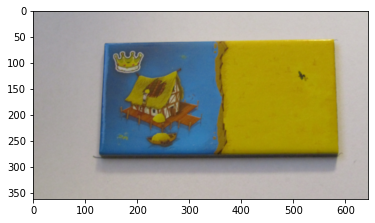

In [26]:
plt.imshow(tmp)

In [ ]:
plt.imshow(tmp2)

In [ ]:
tmp2 = cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)
plt.imshow(tmp2, cmap="gray")

In [ ]:
np.mean(tmp2)
tmp3 = tmp2.copy()

# There are four primary boundaries on these photos
# 1) the white paper, which has a high intensity
# 2) the shadow the rectangle is casting, which has a high intensity but lower than paper
# 3) the edge of the rectangle, usually only visilbe in the font as a thick black line
# 4) the rectangle itself.

upper_threshold = np.mean(tmp2)  # eliminate paper
lower_threshold = np.mean(tmp2) - 4*np.std(tmp2) # eliminate shadow
mask = tmp2 < upper_threshold
tmp3[mask] = 255
tmp3[~mask] = 0

In [ ]:
plt.imshow(tmp3, cmap="gray")

In [ ]:
def maskIm(mask, image):
    result = np.zeros(image.shape).astype(image.dtype)
    for c in range(3):
        result[:,:,c] = (mask > 0) * image[:, :, c]
    return result

plt.imshow(maskIm(tmp3, tmp)/255,cmap="gray")

In [ ]:
debug = (tmp2 - np.mean(tmp2)) / np.std(tmp2)
plt.imshow(debug)

In [ ]:
H, W = tmp3.shape
test = np.nonzero(tmp3)
extent_x = [ W, W, 0, 0 ]
extent_y = [ 0, H, 0, H ]
midx = W // 2
midy = H // 2
for (y, x) in zip(test[0], test[1]):
    if (x < midx):
        if (y < midy):
            if (x < extent_x[1]): extent_x[1] = x
            if (y < extent_y[1]): extent_y[1] = y
        else:
            if (x < extent_x[0]): extent_x[0] = x
            if (y > extent_y[0]): extent_y[0] = y
    else:
        if (y < midy):
            if (x > extent_x[3]): extent_x[3] = x
            if (y < extent_y[3]): extent_y[3] = y
        else:
            if (x > extent_x[2]): extent_x[2] = x
            if (y > extent_y[2]): extent_y[2] = y
            
for i in range(4):
    print("quadrant {0} x {1} y {2} ".format(i, extent_x[i], extent_y[i]))

In [ ]:
# the following setups mapping of rhombus identified above to a rectangle with corners (0,0) and (2,1)
T1 = np.zeros((6,6)) 
T2 = np.zeros((6,6))
c1 = np.zeros(6)
c2 = np.zeros(6)

# We break up the rhombus? into two triangles T1 and T2
#  which we will map back to the rectangle (0,0) - (256,128)  (w,h)
#
# Let P be the affine matrix mapping the triangle T1 from extent 0 - 1 - 3
#  then

#   P1 = ( a b c      [x y 1]^T 
#          d e f
#          0 0 1 )
#
#  And similarly for Q mapping T2 (for six other variables).  
#


T1 = np.array([
    [extent_x[1], extent_y[1], 1,           0, 0, 0],
    [extent_x[0], extent_y[0], 1,           0, 0, 0],
    [extent_x[3], extent_y[3], 1,           0, 0, 0],
    [          0,           0, 0, extent_x[1], extent_y[1], 1],
    [          0,           0, 0, extent_x[0], extent_y[0], 1],
    [          0,           0, 0, extent_x[3], extent_y[3], 1]
])
c1 = [ 0, 0, 256, 0, 128, 0 ]

T2 = np.array([
    [extent_x[2], extent_y[2], 1,           0, 0, 0],
    [extent_x[0], extent_y[0], 1,           0, 0, 0],
    [extent_x[3], extent_y[3], 1,           0, 0, 0],
    [          0,           0, 0, extent_x[2], extent_y[2], 1],
    [          0,           0, 0, extent_x[0], extent_y[0], 1],
    [          0,           0, 0, extent_x[3], extent_y[3], 1]
])
c2 = [ 256, 0, 256, 128, 128, 0 ]

t1_est = np.linalg.solve(T1, c1)
t2_est = np.linalg.solve(T2, c2)

P = np.array([
    [t1_est[0], t1_est[1], t1_est[2]],
    [t1_est[3], t1_est[4], t1_est[5]],
    [        0,         0,         1]])

Pinv = np.linalg.inv(P)

Q = np.array([
    [t2_est[0], t2_est[1], t2_est[2]],
    [t2_est[3], t2_est[4], t2_est[5]],
    [        0,         0,         1]])
Qinv = np.linalg.inv(Q)

In [ ]:
def t1IMap(xs, ys):
    rx = Pinv[0, 0] * xs + Pinv[0, 1] * ys + Pinv[0, 2]
    ry = Pinv[1, 0] * xs + Pinv[1, 1] * ys + Pinv[1, 2]
    return rx, ry
    
def t2IMap(xs, ys):
    rx = Qinv[0, 0] * xs + Qinv[0, 1] * ys + Qinv[0, 2]
    ry = Qinv[1, 0] * xs + Qinv[1, 1] * ys + Qinv[1, 2]
    return rx, ry


In [ ]:
ys, xs= np.mgrid[0:128, 0:256]
t1_oxs, t1_oys = t1IMap(xs, ys)
t2_oxs, t2_oys = t2IMap(xs, ys)

In [ ]:
plt.scatter(t1_oxs, t1_oys)

In [ ]:
plt.scatter(t2_oxs, t2_oys)

In [ ]:
old_grid_y, old_grid_x = np.mgrid[0:H, 0:W]
t1_interp = griddata(np.stack((old_grid_x, old_grid_y)).transpose().reshape(-1, 2), tmp2.T.flatten(), (t1_oxs, t1_oys))
t2_interp = griddata(np.stack((old_grid_x, old_grid_y)).transpose().reshape(-1, 2), tmp2.T.flatten(), (t2_oxs, t2_oys))

In [ ]:
plt.imshow(t1_interp, cmap="gray")

In [ ]:
plt.imshow(t2_interp, cmap="gray")

In [ ]:
old_grid_y

In [ ]:
# Get a mask to pick which map we use for each pixel, T1 or T2
# first we find the slope of the line
new_grid_y, new_grid_x = np.mgrid[0:128, 0:256]

slope = 0.5
mask = (128 - new_grid_y) < slope*new_grid_x
mask = ~mask
plt.imshow(mask)

In [ ]:
t_combined = np.zeros(t1_interp.shape)
t_combined[mask] = t1_interp[mask]
t_combined[~mask] = t2_interp[~mask]
plt.imshow(t_combined, cmap="gray")

In [ ]:
t1_interp.shape